# Image Quality Transfer (IQT) in MRI with Deep Neural Networks

- MediCSS Project
- 06/07/2020 v1.2
- Project leads: Harry Hongxiang Lin, Matteo Figini
- Acknowledgement: Ryutaro Tanno (Microsoft Research Cambridge)
- Language: Python+Keras+Tensorflow

History:
- v1.2: Simplify the installation procedure.
- v1.1.1: Fix bugs on coding-style transfer from Python 2 to 3.

This notebook provides a demo on IQT using deep learning. IQT can enhance resolution on slice thickness direction by learning a upsampling deep neural network from low- and high-resolution paired data. Human Connetome Project (HCP) dataset will be provided for evaluating the effectiveness of the algorithm.

In this project, we expect to deliver practical knowledge of deep learning, especially on:
- Understanding a general structure of pipeline for a deep learning task: data preprocessing-training-test-evaluation;
- Apply external datasets to the trained networks;
- Visualise and evaluate the neural network in order to have some intuitions about deep learning.

## Prerequisites

### Material [Provide by request]
1. Dataset [Human Connectome Project dataset](http://www.humanconnectomeproject.org/): 5 processed subjects.
2. Pre-trained models: 3D SR U-net `srunet16_16_2_nf4` and Anisotropic U-net `anisounet16_16_2_nf4`.

### Configure `config.py`

Configure `config.py` under the IQT project folder `IQT_tutorial`:
1. In `general_configuration`, substitute `<YOUR HOME DIRECTORY>` in `dataset_path` and `base_path` with your home directory path. For example, here is my setting:
    `'dataset_path' : '/home/harrylin/'` and `'base_path' : '/home/harrylin/tutorial_result'`.
2. Put the pretrained models, `srunet16_16_2_nf4` and `anisounet16_16_2_nf4`, into the `base_path`. Then set `'job_name' : 'srunet16_16_2_nf4'` or `'job_name' : 'anisounet16_16_2_nf4'`.
3. [Done] Set `dataset_info` for the new including dataset. An example for `HCP-Wu-Minn-Contrast` dataset is given.
4. In `training_configuration`, choose `approach` and `dataset` for training/test. The alternatives for `approach`: `SRUnet` and `AnisoUnet` corresponding to the pretrained models `'srunet16_16_2_nf4'` and `'anisounet16_16_2_nf4'`, respectively.

## Data preparation
- The module loads the technical configuration on dataset and neural networks.
- Create folders for saving results.


In [1]:
from config import general_configuration as gen_conf
from config import training_configuration as train_conf
from workflow.data_preparation import data_preparation

# pass arguments to jupyter notebook
import sys
sys.argv = ['main.py', '--gpu', '0']

# data preparation
opt, gen_conf, train_conf = data_preparation(gen_conf, train_conf)

## Input data simulation
- Downsample HCP dataset
- The simulated downsampling data will be saved in the folder of each subject `<dataset_path>/<path>/subject...`.

In [2]:
from utils.preprocessing_util import preproc_dataset
preproc_dataset(gen_conf, train_conf)

Downsample HCP data with 1D Gaussian filter.
Processing '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214019/T1w_acpc_dc_restore_brain.nii'
Save to '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214019/T1w_acpc_dc_restore_brain_procin.nii'
Processing '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214221/T1w_acpc_dc_restore_brain.nii'
Save to '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214221/T1w_acpc_dc_restore_brain_procin.nii'
Processing '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214423/T1w_acpc_dc_restore_brain.nii'
Save to '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214423/T1w_acpc_dc_restore_brain_procin.nii'
Processing '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214524/T1w_acpc_dc_restore_brain.nii'
Save to '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214524/T1w_acpc_dc_restore_brain_procin.nii'
Processing '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214625/T1w_acpc_dc_restore_brain.nii'
Save to '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214625/T1w_acpc_dc_restore_brain_procin.nii'


True

### Example: Visualize the downsampled MRI images

Please select one subject from the training set and visualize one downsampled image (input) together with its original image (output) on axial/coronal/sagittal views. Suggest using Python libs: `nibabel` (https://nipy.org/nibabel/coordinate_systems.html) to read and `matplotlib` (https://matplotlib.org/gallery/index.html) to plot.

/cs/student/msc/misc/2019/ucact21/miniconda/envs/iqt/lib/python3.6/site-packages/numpy/core/memmap.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = super(memmap, self).__getitem__(index)


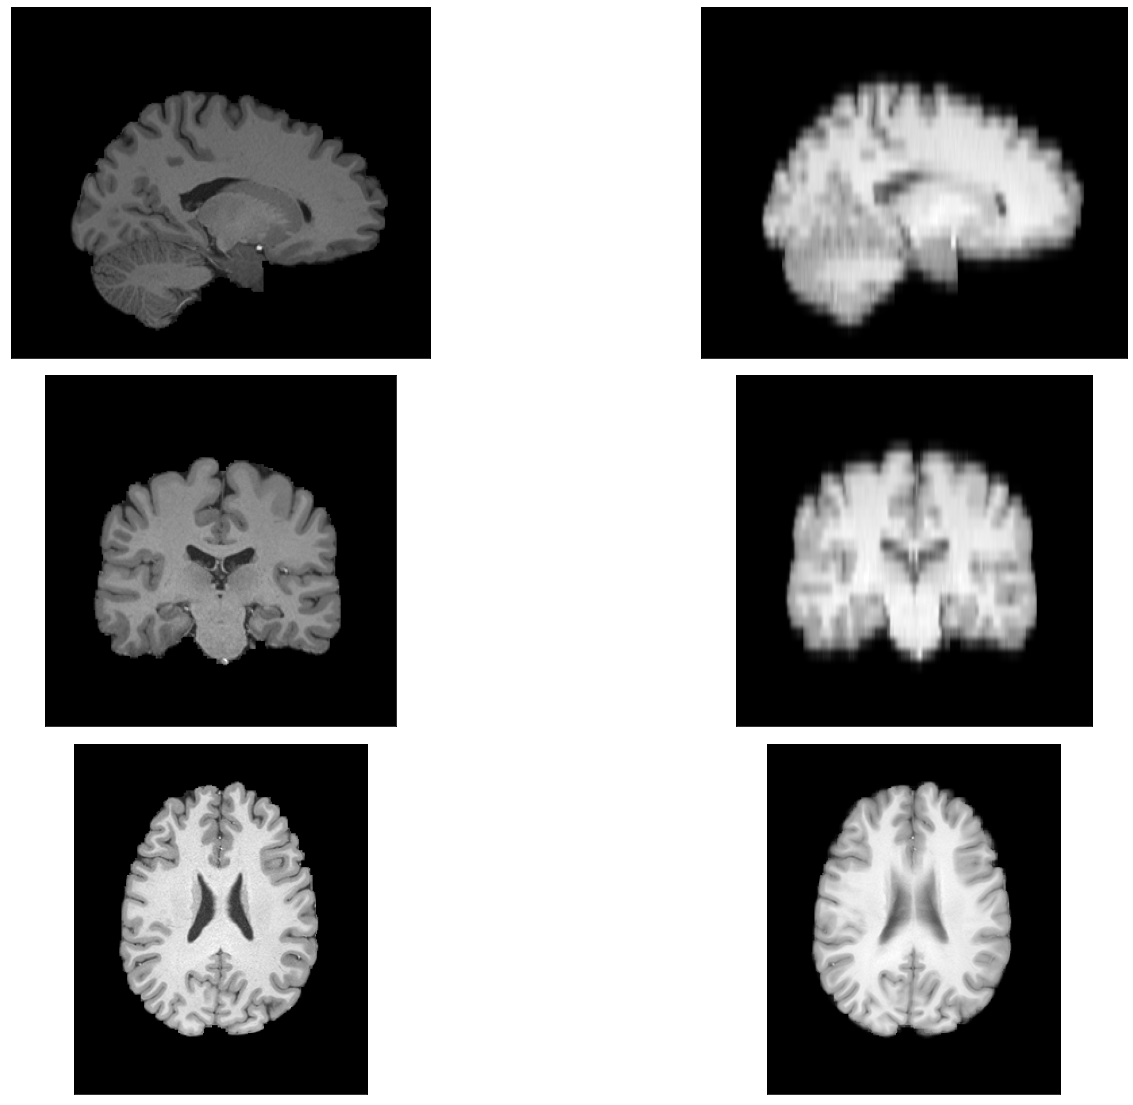

In [4]:
## Sample answer.

# load the subject 200008
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

# image file paths
## gt=ground truth, proc = pre-processed
gt_img_path = '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214019/T1w_acpc_dc_restore_brain.nii'
proc_img_path = '/cs/student/msc/misc/2019/ucact21/hcp/HCP/214019/T1w_acpc_dc_restore_brain_procin.nii'

gt_img = nib.load(gt_img_path).get_data()
proc_img = nib.load(proc_img_path).get_data()

# Plot images in a 2x3 grid. Cross-sectional views by row w/o downsampling by column.
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10*2, 10*2),
                        subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.05, wspace=0.05)

## Intersection of 3 viewing planes (axial/coronal/sagittal) 
# intersection coordinate at original image
gt_intersect = [150, 150, 128]
# sparse scale
sparse_scale = gen_conf['dataset_info']['HCP-Wu-Minn-Contrast']['sparse_scale']
apsect_ratio_scale = np.prod(sparse_scale)//np.array(sparse_scale)
# intersection coordinate at processed image
proc_intersect = np.array(gt_intersect)//np.array(sparse_scale)

for idx, ax in enumerate(axs):
    # initialisation
    gt_coord = [slice(None), slice(None), slice(None)]
    proc_coord = [slice(None), slice(None), slice(None)]
    
    # 
    gt_coord[idx] = slice(gt_intersect[idx], gt_intersect[idx]+1, 1)
    proc_coord[idx] = slice(proc_intersect[idx], proc_intersect[idx]+1, 1)
    
    gt_reduced_img = np.squeeze(gt_img[gt_coord])
    ax[0].imshow(gt_reduced_img.T, interpolation=None, cmap='gray', aspect=1, origin='lower')
    
    proc_reduced_img = np.squeeze(proc_img[proc_coord])
    ax[1].imshow(proc_reduced_img.T, interpolation=None, cmap='gray', aspect=apsect_ratio_scale[idx], origin='lower')


## Test stage

We provide a SRU-net pre-trained from the Human Connectome Project (HCP) dataset. 

In [5]:
from workflow.test import testing

model = testing(gen_conf, train_conf)

Using TensorFlow backend.
/cs/student/msc/misc/2019/ucact21/miniconda/envs/iqt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cs/student/msc/misc/2019/ucact21/miniconda/envs/iqt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cs/student/msc/misc/2019/ucact21/miniconda/envs/iqt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

Start testing ... load data, mean, std and model...
5 1 (260, 311, 32)
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/models/HCP-Wu-Minn-Contrast/1-SRUnet-3-(32, 32, 4)-(16, 16, 2)_mean.npz
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/models/HCP-Wu-Minn-Contrast/1-SRUnet-3-(32, 32, 4)-(16, 16, 2)_std.npz
Instructions for updating:
Colocations handled automatically by placer.
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/models/HCP-Wu-Minn-Contrast/1-SRUnet-3-(32, 32, 4)-(16, 16, 2).h5
Test model ...


/cs/student/msc/misc/2019/ucact21/miniconda/envs/iqt/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function extract_patches is deprecated; The function feature_extraction.image.extract_patches has been deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(msg, category=FutureWarning)


5780/5780 [==============================] - 12s 2ms/step
Reconstructing ...


/cs/student/msc/misc/2019/ucact21/IQT_tutorial/utils/reconstruction.py:50: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rec_volume[selection] += patches[output_selector][count]   ## non-padding
/cs/student/msc/misc/2019/ucact21/IQT_tutorial/utils/reconstruction.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rec_patch_count[selection] += output_patch_volume


/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214019_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
Save file at /cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214019_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
5780/5780 [==============================] - 10s 2ms/step
Reconstructing ...
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214221_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
Save file at /cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214221_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
5780/5780 [==============================] - 9s 1ms/step
Reconstructing ...
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214423_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
Save file at /cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214423_T1w

### Assignments:

1. Show summary of networks, which is saved in the variable `model` (Hint: Using `model.summary()` https://keras.io/models/about-keras-models/).
2. Visualise the activation for each layer (Hint: https://keras.io/examples/vision/grad_cam/).
3. Use other datasets (e.g. HBN, IBSR) for predicting the network outputs.

HBN: Child Mind Institute Healthy Brain Network http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/index.html

IBSR: Internet Brain Segmentation Repository https://www.nitrc.org/projects/ibsr/

In [ ]:
# Write the answer here.

## Evaluation
Evaluation metrics:
1. PSNR: Peak Signal-to-Noise Ratio
2. SSIM: Structural Similarity Index
3. RMSE: Root Mean Squared Error

### Assigments:
1. Look at the evaluation result under `</task_name/>/evaluation/stats_brain.csv` and compare results from the different networks.
2. Read the reference on SSIM, https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf, and intuitively and/or theoretically explain if this index is suitable to MR image quality assessment.


In [6]:
from workflow.evaluation import evaluation

evaluation(gen_conf, train_conf)

5 1 (260, 311, 32)
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214019_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214221_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214423_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214524_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii
/cs/student/msc/misc/2019/ucact21/hcp/pretrain/srunet16_16_2_nf4/result/HCP-Wu-Minn-Contrast/214625_T1w-SRUnet-3-(32, 32, 4)-(16, 16, 2).nii


/cs/student/msc/misc/2019/ucact21/IQT_tutorial/utils/image_evaluation.py:206: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  multichannel=True)
